This notebook shows how to use the general interface in HiGP for regression problems with a PyTorch optimizer.

We will apply GP to a one-dimensional dataset $X$ randomly sampled from $[0,1]$. The corresponding label is generated using a Gaussian Random Field. The data is stored in the file "Example00-EasyGPR.npz".

In this example, we use the Matern 3/2 kernel function in the form
$$
\mathcal{K}(x,y)=f^2 (1 + \sqrt{3} \frac{\|x - y\|_2}{l}) \exp\left(\frac{-\sqrt{3}\|x - y\|_2}{l}\right).
$$

As we hope to make the actual parameters in $(0,\infty)$, we train our parameters in $\mathbb{R}$, and apply the softplus transformation to get the actual parameters.

In [1]:
import higp
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

Load the dataset.

In [2]:
np_dtype = np.float32
data = np.load("Example00-EasyGPR.npz")
train_x = data["train_x"].astype(np_dtype)
train_y = data["train_y"].astype(np_dtype)
test_x = data["test_x"].astype(np_dtype)
test_y = data["test_y"].astype(np_dtype)

n_train = train_x.shape[1]
n_test = test_x.shape[1]

Create a GP regression model and a PyTorch Adam optimizer.

We use Matern 3/2 kernel by using `higp.Matern32Kernel`.

In [3]:
torch_dtype = torch.float32 if np_dtype == np.float32 else torch.float64
gprproblem = higp.gprproblem.setup(data=train_x, label=train_y, kernel_type=higp.Matern32Kernel)
model = higp.GPRModel(gprproblem, dtype=torch_dtype)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Setting up GPR problem with 400 samples and 1 features
Init gpr problem done
Creating GPR problem
Data type: float
Kernel type: Matern 3/2
Transform type: softplus
Using preconditioned GP, kernel matrix form: dense / fall back to on-the-fly
AFN preconditioner parameters: rank 50, lfil 0
LanQ parameters: niter 10, nvec 10


Run 50 steps of Adam.

In [4]:
loss_history, param_histpry = higp.gpr_torch_minimize(model, optimizer, maxits=50, print_info=True)

Iteration (max 50), Elapsed time (sec), Loss, Hyperparameters (l, s, f, before nnt)
1, 0.02, 0.95128, -0.100, -0.100, 0.100
2, 0.04, 0.90626, -0.200, -0.200, 0.200
3, 0.06, 0.85815, -0.300, -0.300, 0.300
4, 0.08, 0.80709, -0.401, -0.401, 0.400
5, 0.10, 0.75379, -0.502, -0.502, 0.501
6, 0.12, 0.69925, -0.603, -0.603, 0.600
7, 0.14, 0.64451, -0.704, -0.704, 0.698
8, 0.16, 0.59045, -0.804, -0.806, 0.795
9, 0.18, 0.53773, -0.902, -0.909, 0.889
10, 0.20, 0.48683, -0.998, -1.012, 0.979
11, 0.22, 0.43796, -1.090, -1.115, 1.064
12, 0.25, 0.39113, -1.177, -1.218, 1.144
13, 0.27, 0.34614, -1.259, -1.322, 1.218
14, 0.29, 0.30269, -1.334, -1.426, 1.286
15, 0.31, 0.26043, -1.401, -1.531, 1.346
16, 0.33, 0.21903, -1.460, -1.636, 1.400
17, 0.35, 0.17820, -1.510, -1.740, 1.446
18, 0.37, 0.13769, -1.551, -1.845, 1.485
19, 0.39, 0.09731, -1.583, -1.950, 1.517
20, 0.41, 0.05690, -1.606, -2.055, 1.542
21, 0.44, 0.01639, -1.620, -2.161, 1.561
22, 0.46, -0.02430, -1.625, -2.265, 1.573
23, 0.48, -0.06515, -1

Run predictions with the initial parameters and the trained parameters.

In [5]:
Pred0 = higp.gpr_prediction(data_train=train_x,
                            label_train=train_y,
                            data_prediction=test_x,
                            kernel_type=higp.Matern32Kernel,
                            gp_params=np.hstack((0.0, 0.0, 0.0)))   # Initial parameters

Pred = higp.gpr_prediction(data_train=train_x,
                           label_train=train_y,
                           data_prediction=test_x,
                           kernel_type=higp.Matern32Kernel,
                           exact_gp=0,
                           gp_params=model.get_params())            # Trained parameters

Running GPR prediction
Data type: float
Kernel type: Matern 3/2
Transform type: softplus
Using preconditioned GP, kernel matrix form: dense / fall back to on-the-fly
AFN preconditioner parameters: rank 50, lfil 0
PCG parameters: niter 50, tol 1e-06
Running GPR prediction
Data type: float
Kernel type: Matern 3/2
Transform type: softplus
Using preconditioned GP, kernel matrix form: dense / fall back to on-the-fly
AFN preconditioner parameters: rank 50, lfil 0
PCG parameters: niter 50, tol 1e-06


Now let us check the root mean squared errir (RMSE) of the predition.

In [6]:
rmse0 = np.linalg.norm(Pred0.prediction_mean - test_y) / np.sqrt(float(n_test))
rmse = np.linalg.norm(Pred.prediction_mean - test_y) / np.sqrt(float(n_test))
print("RMSE (before training): %g, RMSE (after training): %g\n" % (rmse0, rmse))

RMSE (before training): 0.460758, RMSE (after training): 0.091559



Finally, plot the results.

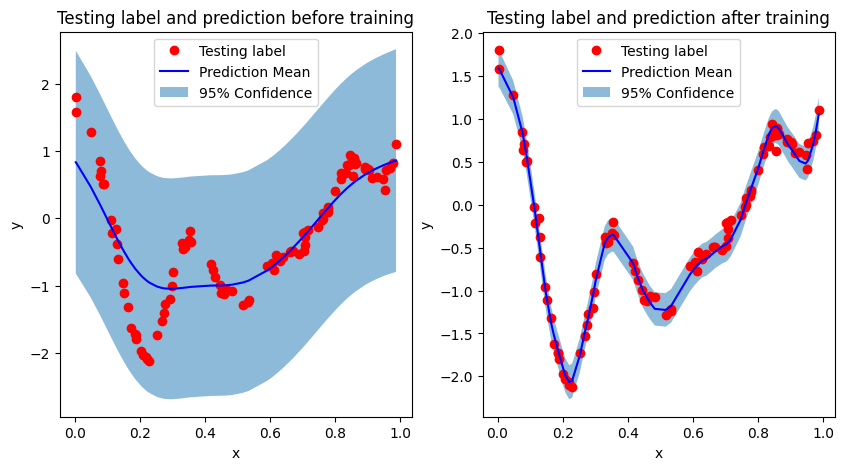

In [7]:
idx = np.argsort(test_x[0,:])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pred0_mean = Pred0.prediction_mean
pred0_stddev = Pred0.prediction_stddev
pred_mean = Pred.prediction_mean
pred_stddev = Pred.prediction_stddev

axs[0].plot(test_x[0,idx], test_y[idx], 'ro')
axs[0].plot(test_x[0,idx], pred0_mean[idx], 'b-')
axs[0].fill_between(test_x[0,idx], pred0_mean[idx] - 1.96 * pred0_stddev[idx], pred0_mean[idx] + 1.96 * pred0_stddev[idx], alpha=0.5)
axs[0].set_title('Testing label and prediction before training')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
axs[1].plot(test_x[0,idx], test_y[idx], 'ro')
axs[1].plot(test_x[0,idx], pred_mean[idx], 'b-')
axs[1].fill_between(test_x[0,idx], pred_mean[idx] - 1.96 * pred_stddev[idx], pred_mean[idx] + 1.96 * pred_stddev[idx], alpha=0.5)
axs[1].set_title('Testing label and prediction after training')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
plt.show()
plt.close(fig)